In [805]:

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import itertools



# Read in Excel Data
EXCEL_FILE = 'src/results/aggregated_results.xlsx'
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-1x10-4')
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-5x10-4')
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-10x10-4')
df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-100x10-4_NEW')
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'Valid Records')

# Ensure Relative Gap is numeric and fill NAs with a high value to mark them as invalid
# Generate Instance column and populate

""" def create_name(row):
    return f"Network{row['Network']}.{row['Relaxation']}.{row['Demand']}.{row['Eta']}.{row['Horizon']}.{row['Tau Range']}"
df['Instance'] = df.apply(create_name, axis=1) """

df['Relative Gap'] = pd.to_numeric(df['Relative Gap'], errors='coerce')  # Convert to numeric, coerce bad values to NaN
df['Relative Gap'] = df['Relative Gap'].fillna(999)  # Treat NaNs as invalid by setting a large dummy value

# --- FILTER 1: filter out instances with any formulation having Relative Gap > 0.005
invalid_instances = df[
    (df['Time (s)'] < 1)
    #| (df['Relative Gap'] > 1)         
    | (df['Time (s)'] > 54000)
]['Instance'].unique()

df_filtered = df[~df['Instance'].isin(invalid_instances)].copy()

print(len(df_filtered))

print(f"First filter-Remove if there is at least 1 formulation not solved: {invalid_instances}")

# --- FILTER 2: filter out instances where all formulations have solution time less than "x" or greater than "y"
def all_gaps_above_threshold(group):
    return (
        (group['Time (s)'] <= 600) 
        #| (group['Time (s)'] > 54000) 
        ).all()

# Get instances to remove
instances_to_remove = df_filtered.groupby('Instance').filter(all_gaps_above_threshold)['Instance'].unique()
print(f"Second filter-Remove if all solve in less than 500 s: {instances_to_remove}")

# Filter out those instances
df_filtered = df_filtered[~df_filtered['Instance'].isin(instances_to_remove)].copy()

print(len(df_filtered))

# Plot selected formulations for comparison
selected_formulations = ['F1_Base_Model', 
                        'F2_X_YS_0_EST', 
                        'F3_UB_YS_Task', 
                        'F4_UB_YS_Unit', 
                        'F5_UB_X_Task', 
                        'F6_UB_X_Unit', 
                        'F7_UB_X_Group_K', 
                        'F8_UB_YS_Group_K', 
                        'F9_UB_YS_Task_Unit', 
                        'F10_UB_X_Task_Unit', 
                        'F11_UB_X_YS_Group_K', 
                        'F12_All'
                        ]
df_filtered = df_filtered[df_filtered['Formulation'].isin(selected_formulations)].copy()

# Identify all unique formulations
all_formulations = df_filtered['Formulation'].unique()
print(f"All formulation: {all_formulations}")
formulation_counts = df_filtered.groupby('Instance')['Formulation'].nunique()

# Keep only instances that have data from all formulations
complete_instances = formulation_counts[formulation_counts == len(all_formulations)].index
incomplete_instances = formulation_counts[formulation_counts != len(all_formulations)].index
print(f"Third filter-Not all intances were solve: {incomplete_instances}")
df_filtered = df_filtered[df_filtered['Instance'].isin(complete_instances)].copy()

# Sort instances by minimum time for plotting
instance_order = df_filtered.groupby('Instance')['Time (s)'].min().sort_values().index

print(len(instance_order))


996
First filter-Remove if there is at least 1 formulation not solved: ['network_3_5_50_1.2_0.4_100' 'network_3_5_50_1.2_0.8_100'
 'network_3_5_60_1.2_0.4_100' 'network_3_5_60_1.2_0.8_100'
 'network_4_5_50_2.0_0.4_100' 'network_4_5_60_2.0_0.8_100'
 'network_4_1_60_1.2_0.4_100' 'network_4_5_60_1.2_0.4_100'
 'network_3_1_50_1.2_0.4_100' 'network_4_5_50_2.0_0.8_100'
 'network_4_5_60_2.0_0.4_100' 'network_3_5_60_2.0_0.4_100'
 'network_4_1_60_1.2_0.8_100']
Second filter-Remove if all solve in less than 500 s: ['network_3_0_50_1.2_0.8_100' 'network_4_1_30_1.2_0.8_100'
 'network_4_5_30_2.0_0.8_100' 'network_3_1_40_2.0_0.8_100'
 'network_3_0_40_2.0_0.8_100' 'network_4_5_30_1.2_0.4_100'
 'network_3_0_60_2.0_0.8_100' 'network_4_1_40_2.0_0.8_100'
 'network_4_0_40_1.2_0.4_100' 'network_3_0_50_2.0_0.8_100'
 'network_3_1_30_1.2_0.8_100' 'network_3_1_30_1.2_0.4_100'
 'network_3_5_30_1.2_0.8_100' 'network_3_1_40_1.2_0.8_100'
 'network_4_0_50_2.0_0.4_100' 'network_3_0_60_1.2_0.8_100'
 'network_4_1_30_2

Formulation = F10_UB_X_Task_Unit, SGM = 1761.2193390067632, AM = 3788.2319047619053
Formulation = F11_UB_X_YS_Group_K, SGM = 1789.9646095397638, AM = 3326.7747619047623
Formulation = F12_All, SGM = 1655.165157894484, AM = 2846.5290476190476
Formulation = F1_Base_Model, SGM = 1655.601075585363, AM = 3609.6385714285716
Formulation = F2_X_YS_0_EST, SGM = 1789.8984430690173, AM = 3238.9511904761907
Formulation = F3_UB_YS_Task, SGM = 1684.3776891897776, AM = 3557.0726190476194
Formulation = F4_UB_YS_Unit, SGM = 1634.0149184870445, AM = 2522.124285714285
Formulation = F5_UB_X_Task, SGM = 1575.225329742139, AM = 2619.807857142857
Formulation = F6_UB_X_Unit, SGM = 1573.626950742291, AM = 3318.0933333333337
Formulation = F7_UB_X_Group_K, SGM = 1792.7105655240287, AM = 3583.8819047619045
Formulation = F8_UB_YS_Group_K, SGM = 1648.7413958222126, AM = 3324.9495238095237
Formulation = F9_UB_YS_Task_Unit, SGM = 1666.9414748016748, AM = 3057.7654761904764


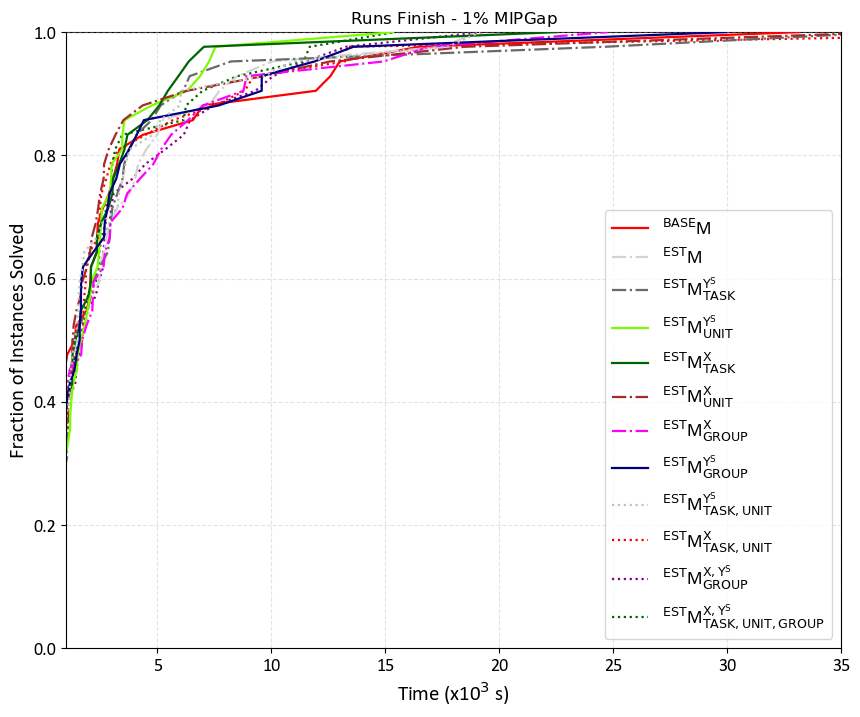

Number of unique instances before filtering: 96
Number of instances used in performance chart: 42


In [806]:
# Create a mapping for instances to y-axis positions
instance_mapping = {inst: i for i, inst in enumerate(instance_order)}
df_filtered['Y Position'] = df_filtered['Instance'].map(instance_mapping)

# Define custom styles for individual formulation curves
formulation_styles = {

    'F1_Base_Model': {'linestyle': 'solid', 'marker': 'o', 'color': 'red'},
    'F2_X_YS_0_EST': {'linestyle': 'dashdot', 'marker': '*', 'color': 'lightgray'},
    'F3_UB_YS_Task': {'linestyle': 'dashdot', 'marker': 'p', 'color': 'dimgray'},
    'F4_UB_YS_Unit': {'linestyle': 'solid', 'marker': 'D', 'color': 'lawngreen'},
    'F5_UB_X_Task': {'linestyle': 'solid', 'marker': 's', 'color': 'darkgreen'},
    'F6_UB_X_Unit': {'linestyle': 'dashdot', 'marker': '^', 'color': 'brown'},
    'F7_UB_X_Group_K': {'linestyle': 'dashdot', 'marker': '+', 'color': 'magenta'},
    'F8_UB_YS_Group_K': {'linestyle': 'solid', 'marker': 'o', 'color': 'navy'},
    'F9_UB_YS_Task_Unit': {'linestyle': 'dotted', 'marker': '*', 'color': 'silver'},
    'F10_UB_X_Task_Unit': {'linestyle': 'dotted', 'marker': 'p', 'color': 'red'},
    'F11_UB_X_YS_Group_K': {'linestyle': 'dotted', 'marker': 'D', 'color': 'darkmagenta'},
    'F12_All': {'linestyle': 'dotted', 'marker': 's', 'color': 'darkgreen'},
    #'F13_UB_X_YS_Group_K': {'linestyle': (0, (3, 5, 1, 5)), 'marker': '^', 'color': 'gold'},
    #'F14_All': {'linestyle': 'solid', 'marker': 'o', 'color': 'darkblue'},
    #'F14_All': {'linestyle': (0, (3, 1, 1, 1)), 'marker': '+', 'color': 'cyan'},
}

formulation_handles = {}

# Desired order of formulations in the legend
desired_legend_order = ['F1_Base_Model', 
                        'F2_X_YS_0_EST', 
                        'F3_UB_YS_Task', 
                        'F4_UB_YS_Unit', 
                        'F5_UB_X_Task', 
                        'F6_UB_X_Unit', 
                        'F7_UB_X_Group_K', 
                        'F8_UB_YS_Group_K', 
                        'F9_UB_YS_Task_Unit', 
                        'F10_UB_X_Task_Unit', 
                        'F11_UB_X_YS_Group_K', 
                        'F12_All'
                        ]

# Map raw formulation names to pretty LaTeX-style labels
legend_labels = {
    'F12_All' : r'$^{\mathrm{EST}}$M$^{\mathrm{X,Y^{S}}}_{\mathrm{TASK,UNIT,GROUP}}$', 
    'F11_UB_X_YS_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{X,Y^{S}}}_{\mathrm{GROUP}}$',
    'F10_UB_X_Task_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{TASK,UNIT}}$', 
    'F9_UB_YS_Task_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{TASK,UNIT}}$', 
    'F8_UB_YS_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{GROUP}}$', 
    'F7_UB_X_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{GROUP}}$', 
    'F6_UB_X_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{UNIT}}$', 
    'F5_UB_X_Task' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{TASK}}$', 
    'F4_UB_YS_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{UNIT}}$', 
    'F3_UB_YS_Task' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{TASK}}$', 
    'F2_X_YS_0_EST' : r'$^{\mathrm{EST}}$M', 
    'F1_Base_Model' : r'$^{\mathrm{BASE}}$M'
}

# Compute the shifted geometric mean for each formulation
def shifted_geometric_mean(times, shift):
    data = np.array(times)
    product = np.prod(data + shift)
    return product**(1 / len(data)) - shift

# Compute the arithmetic mean for each formulation
def arithmetic_mean(times):
    data = np.array(times)
    return np.mean(data)

am_formulation = {}
sgm_formulation = {}

plt.figure(figsize=(10, 8))

for formulation, group in df_filtered.groupby('Formulation'):

    group_sorted = group.sort_values(by='Time (s)')  # Sort each formulation's data by time
    #print(f'Group Sorted = {group_sorted}')
    total_instances = len(instance_order)
    #print(f'Total Instances = {total_instances}')
    y_positions = (np.arange(len(group_sorted)) + 1) / total_instances  # Normalize to [0, 1]
    #print(f'Y positions = {y_positions}')
    style = formulation_styles.get(formulation, {'linestyle': '-', 'marker': 'o', 'color': 'red'})
    sgm_formulation[formulation] = shifted_geometric_mean(group_sorted['Time (s)'].tolist(), 1)
    am_formulation[formulation] = arithmetic_mean(group_sorted['Time (s)'].tolist())
    print(f'Formulation = {formulation}, SGM = {shifted_geometric_mean(group_sorted['Time (s)'].tolist(), 1)}, AM = {arithmetic_mean(group_sorted['Time (s)'].tolist())}')

    line, = plt.plot(group_sorted['Time (s)'] /1000,
        y_positions,
        linestyle=style['linestyle'],
        # marker=style['marker'],
        color=style['color'],                 # Set the line color
        markerfacecolor=style['color'],       # Explicitly set marker face color
        markeredgecolor=style['color'],       # Explicitly set marker edge color
        markersize=5,                         # Reduced marker size
        linewidth=1.6,                          # Increase line thickness here
        label=legend_labels.get(formulation, formulation))
    formulation_handles[formulation] = line

# Set other plot properties
axis_number_size = 13
axis_label_size = 15
font_family = 'calibri'

plt.xlabel(r'Time (x10$^3$ s)', fontdict={'family': font_family, 'size': axis_label_size})
plt.ylabel("Fraction of Instances Solved", fontdict={'family': font_family, 'size': axis_label_size})
plt.xticks(fontsize=axis_number_size, fontname=font_family)
plt.yticks(fontsize=axis_number_size, fontname=font_family)
plt.tick_params(axis='x', labelsize=axis_number_size)
plt.tick_params(axis='y', labelsize=axis_number_size)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#plt.title('Performance Chart', fontdict={'family': font_family, 'size': 16, 'weight': 'bold'})
plt.grid(True, linestyle='--', alpha=0.35)
#plt.xscale('log')
plt.xlim(1, 35)
plt.ylim(0, 1.00)
top_spine = plt.gca().spines['top']
top_spine.set_zorder(0)  # Move behind the plot lines

# Filter for only the formulations that were actually plotted
ordered_handles = [
    formulation_handles[form] for form in desired_legend_order if form in formulation_handles
]

ordered_labels = [
    legend_labels[form] for form in desired_legend_order if form in formulation_handles
]

# Apply ordered legend
plt.legend(ordered_handles, ordered_labels,
           loc='lower right', prop={'family': font_family, 'size': axis_number_size})

#plt.legend(loc='lower right', title='Formulation', prop={'family': font_family, 'size': axis_number_size})
plt.title(r"Runs Finish - $1\%$ MIPGap")
plt.show()

print(f"Number of unique instances before filtering: {df['Instance'].nunique()}")
print(f"Number of instances used in performance chart: {len(instance_order)}")
#print(instance_order)

{'F6_UB_X_Unit': 1573.626950742291, 'F5_UB_X_Task': 1575.225329742139, 'F4_UB_YS_Unit': 1634.0149184870445, 'F8_UB_YS_Group_K': 1648.7413958222126, 'F12_All': 1655.165157894484, 'F1_Base_Model': 1655.601075585363, 'F9_UB_YS_Task_Unit': 1666.9414748016748, 'F3_UB_YS_Task': 1684.3776891897776, 'F10_UB_X_Task_Unit': 1761.2193390067632, 'F2_X_YS_0_EST': 1789.8984430690173, 'F11_UB_X_YS_Group_K': 1789.9646095397638, 'F7_UB_X_Group_K': 1792.7105655240287}


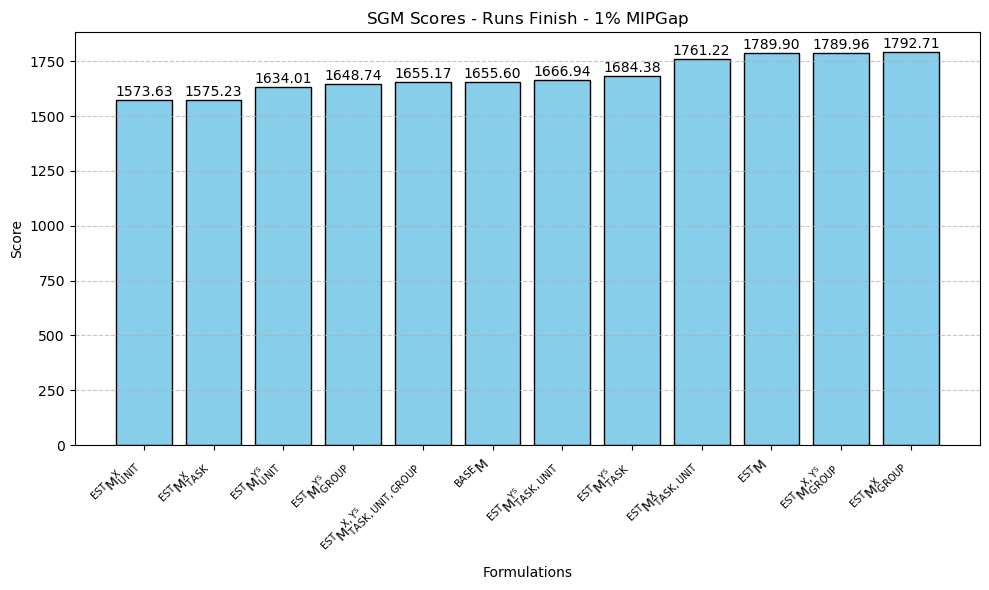

Number of unique instances before filtering: 96
Number of instances used in performance chart: 42


In [807]:
import matplotlib.pyplot as plt

# Sort dictionary by value (ascending)
sgm_formulation_sorted = dict(sorted(sgm_formulation.items(), key=lambda item: item[1]))

# Print sorted dictionary
print(sgm_formulation_sorted)

# Extract keys and values
keys = list(sgm_formulation_sorted.keys())
values = list(sgm_formulation_sorted.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title (update as needed)
plt.xlabel('Formulations')
plt.ylabel('Score')
plt.title(r'SGM Scores - Runs Finish - $1\%$ MIPGap')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + max(values) * 0.01, f'{v:.2f}', ha='center')

# Use LaTeX-style labels from previous dictionary
xtick_labels = [legend_labels.get(k, k) for k in keys]

plt.xticks(ticks=range(len(keys)), labels=xtick_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Number of unique instances before filtering: {df['Instance'].nunique()}")
print(f"Number of instances used in performance chart: {len(instance_order)}")

{'F4_UB_YS_Unit': 2522.124285714285, 'F5_UB_X_Task': 2619.807857142857, 'F12_All': 2846.5290476190476, 'F9_UB_YS_Task_Unit': 3057.7654761904764, 'F2_X_YS_0_EST': 3238.9511904761907, 'F6_UB_X_Unit': 3318.0933333333337, 'F8_UB_YS_Group_K': 3324.9495238095237, 'F11_UB_X_YS_Group_K': 3326.7747619047623, 'F3_UB_YS_Task': 3557.0726190476194, 'F7_UB_X_Group_K': 3583.8819047619045, 'F1_Base_Model': 3609.6385714285716, 'F10_UB_X_Task_Unit': 3788.2319047619053}


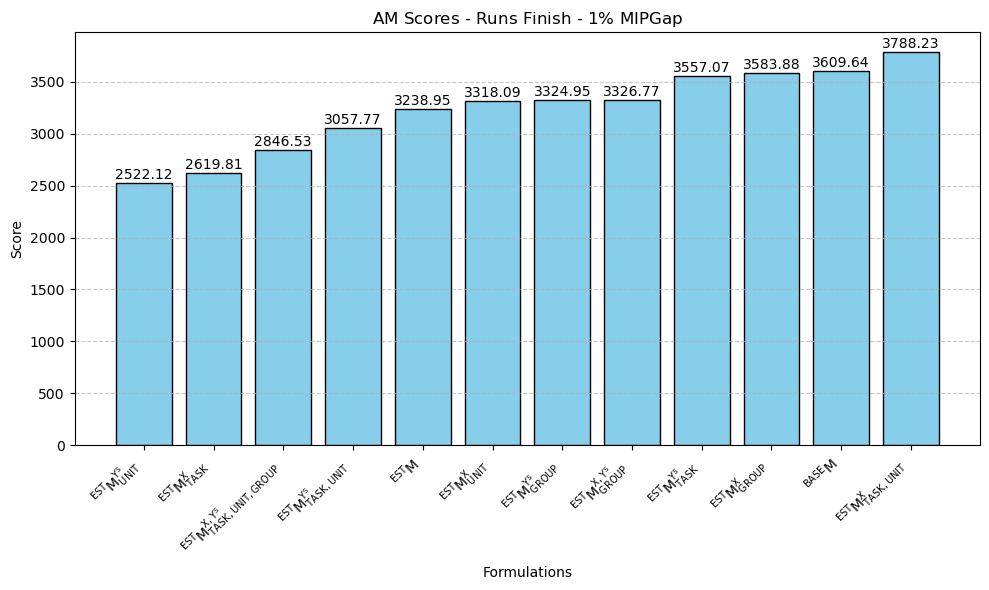

Number of unique instances before filtering: 96
Number of instances used in performance chart: 42


In [808]:
import matplotlib.pyplot as plt

# Sort dictionary by value (ascending)
am_formulation_sorted = dict(sorted(am_formulation.items(), key=lambda item: item[1]))

# Print sorted dictionary
print(am_formulation_sorted)

# Extract keys and values
keys = list(am_formulation_sorted.keys())
values = list(am_formulation_sorted.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title (update as needed)
plt.xlabel('Formulations')
plt.ylabel('Score')
plt.title(r'AM Scores - Runs Finish - $1\%$ MIPGap')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + max(values) * 0.01, f'{v:.2f}', ha='center')

# Use LaTeX-style labels from previous dictionary
xtick_labels = [legend_labels.get(k, k) for k in keys]

plt.xticks(ticks=range(len(keys)), labels=xtick_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Number of unique instances before filtering: {df['Instance'].nunique()}")
print(f"Number of instances used in performance chart: {len(instance_order)}")

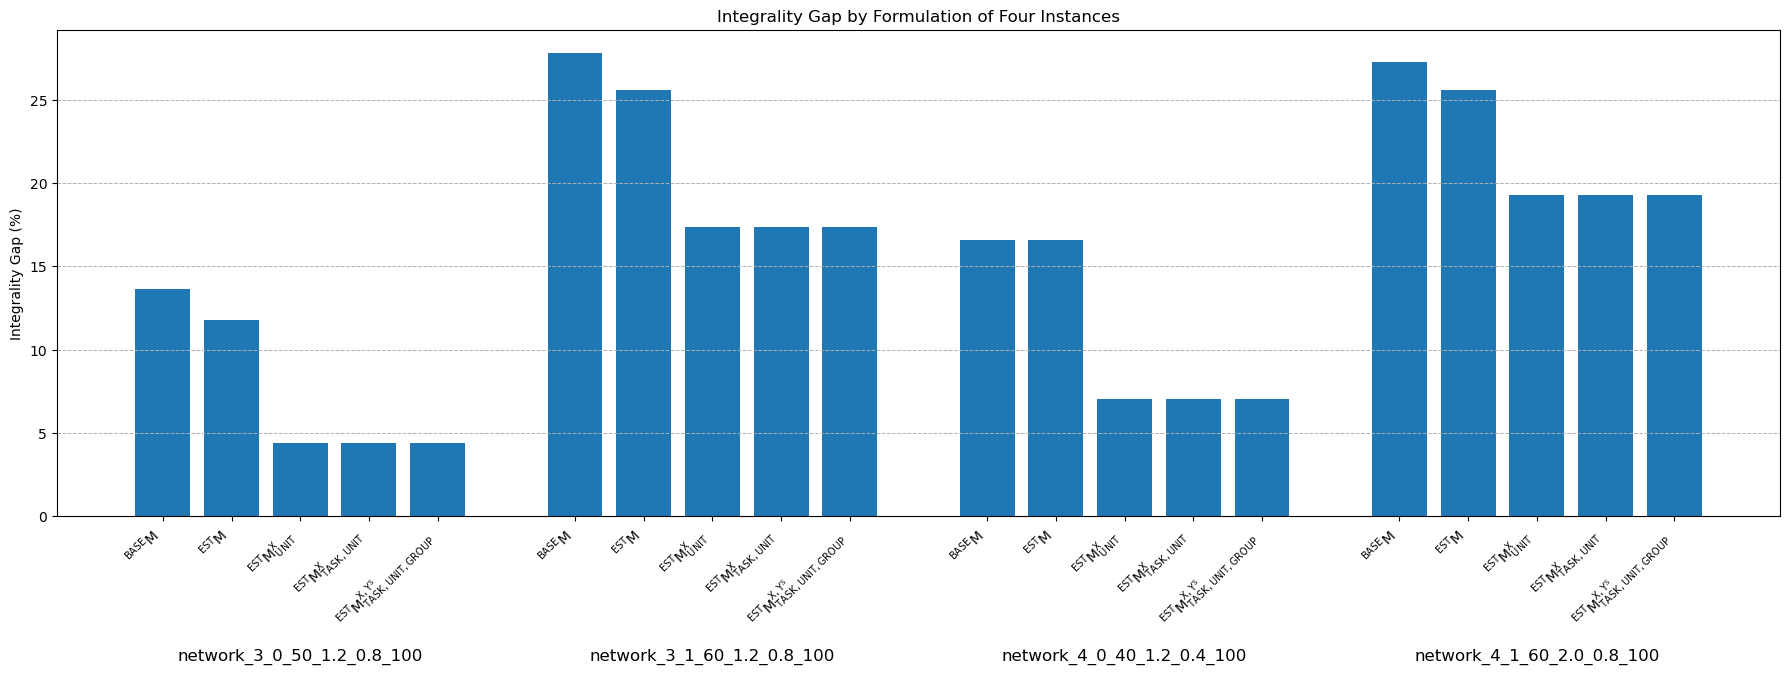

In [816]:
import matplotlib.pyplot as plt
import pandas as pd

EXCEL_FILE = 'src/results/aggregated_results.xlsx'
df = pd.read_excel(EXCEL_FILE, sheet_name='Integrality Gap')

# Desired order of formulations in the legend
desired_legend_order = [
    'F1_Base_Model', 
    'F2_X_YS_0_EST', 
    #'F3_UB_YS_Task', 
    #'F4_UB_YS_Unit',
    #'F5_UB_X_Task', 
    'F6_UB_X_Unit', 
    #'F7_UB_X_Group_K', 
    #'F8_UB_YS_Group_K',
    #'F9_UB_YS_Task_Unit', 
    'F10_UB_X_Task_Unit', 
    #'F11_UB_X_YS_Group_K', 
    'F12_All'
]

# Map raw formulation names to pretty LaTeX-style labels
legend_labels = {
    'F12_All' : r'$^{\mathrm{EST}}$M$^{\mathrm{X,Y^{S}}}_{\mathrm{TASK,UNIT,GROUP}}$', 
    'F11_UB_X_YS_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{X,Y^{S}}}_{\mathrm{GROUP}}$',
    'F10_UB_X_Task_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{TASK,UNIT}}$', 
    'F9_UB_YS_Task_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{TASK,UNIT}}$', 
    'F8_UB_YS_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{GROUP}}$', 
    'F7_UB_X_Group_K' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{GROUP}}$', 
    'F6_UB_X_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{UNIT}}$', 
    'F5_UB_X_Task' : r'$^{\mathrm{EST}}$M$^{\mathrm{X}}_{\mathrm{TASK}}$', 
    'F4_UB_YS_Unit' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{UNIT}}$', 
    'F3_UB_YS_Task' : r'$^{\mathrm{EST}}$M$^{\mathrm{Y^{S}}}_{\mathrm{TASK}}$', 
    'F2_X_YS_0_EST' : r'$^{\mathrm{EST}}$M', 
    'F1_Base_Model' : r'$^{\mathrm{BASE}}$M'
}

# 3. Filter and reorder
df = df[df["Formulation"].isin(desired_legend_order)]
df["Formulation"] = pd.Categorical(df["Formulation"], categories=desired_legend_order, ordered=True)

# 4. Sort data by Instance and Formulation
df = df.sort_values(by=["Instance", "Formulation"])

# 5. Prepare plotting
instances = df["Instance"].unique()
formulations = desired_legend_order
x_labels = []
x_positions = []
y_values = []

bar_width = 0.8
space_between_instances = 1.0  # spacing between groups

pos = 0
instance_positions = {}  # store midpoints for labeling

for inst in instances:
    inst_data = df[df["Instance"] == inst].set_index("Formulation")
    start_pos = pos  # first bar position of this instance
    for form in formulations:
        if form in inst_data.index:
            y_values.append(inst_data.loc[form, "Integrality Gap %"])
            x_labels.append(legend_labels[form])  # use pretty labels
            x_positions.append(pos)
            pos += 1
    end_pos = pos - 1  # last bar position of this instance
    midpoint = (start_pos + end_pos) / 2
    instance_positions[inst] = midpoint
    pos += space_between_instances  # add gap between instances

# 6. Plot
plt.figure(figsize=(18, 7))
plt.bar(x_positions, y_values, width=bar_width)

# X-axis labels for formulations
plt.xticks(x_positions, x_labels, rotation=45, ha="right")

# Add instance names below groups
for inst, mid in instance_positions.items():
    plt.text(mid, -8, inst, ha="center", va="top", fontsize=12)  # adjust -2 if y-min changes

# Y-axis labels & gridlines
plt.ylabel("Integrality Gap (%)")
plt.title("Integrality Gap by Formulation of Four Instances")
plt.grid(axis="y", linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()

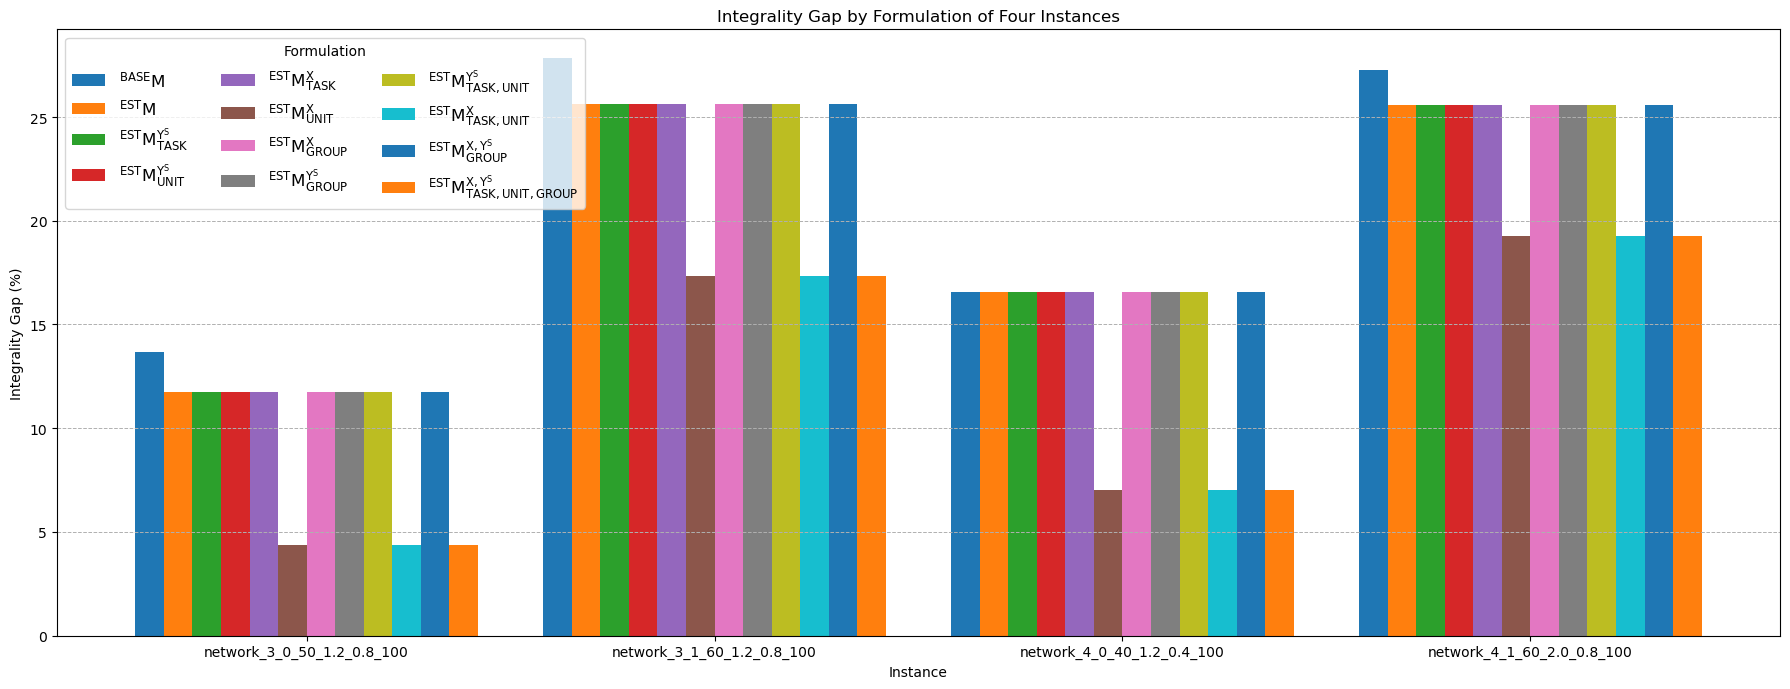

In [813]:
import numpy as np
import matplotlib.pyplot as plt

# Unique instances and formulations
instances = df["Instance"].unique()
formulations = desired_legend_order

# Positions
x = np.arange(len(instances))  # one group per instance
bar_width = 0.07               # width per formulation bar

plt.figure(figsize=(18, 7))

# Plot each formulation as a separate bar offset
for i, form in enumerate(formulations):
    subset = df[df["Formulation"] == form]
    y_vals = subset["Integrality Gap %"].values
    plt.bar(x + i*bar_width, y_vals, width=bar_width, label=legend_labels[form])

# Add instance names centered under each group
group_width = len(formulations) * bar_width
plt.xticks(x + group_width/2 - bar_width/2, instances, rotation=0)

# Labels and title
plt.xlabel("Instance")
plt.ylabel("Integrality Gap (%)")
plt.title("Integrality Gap by Formulation of Four Instances")

# Grid & legend
plt.grid(axis="y", linestyle="--", linewidth=0.7)
plt.legend(title="Formulation", ncol=3, fontsize=12)

plt.tight_layout()
plt.show()